/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


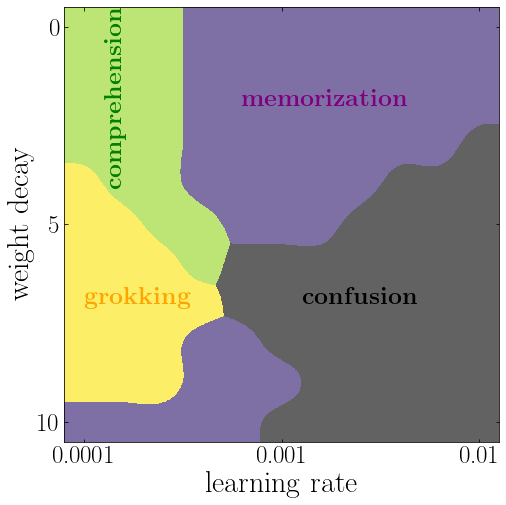

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.linalg
import scipy
import copy
plt.style.use("./mystyle-bright.mplstyle")

plt.figure(figsize=(8,8))

# decoder learning rates
dec_lrs = 10**np.linspace(-4,-2,num=11)
# weight decays
wds = list(np.arange(11))
# load data
train_steps = np.loadtxt('./train_steps.txt')
test_steps = np.loadtxt('./test_steps.txt')
shape = train_steps.shape

# if your data is (learning_rate, weight decay)
transpose_mode = 1
# if your data is (weight decay, learning rate)
#transpose_mode = 0

compute_budget = 1e5
threshold = 1e3 # comprehension -> val-train<threshold; otherwise grokking.
scale = 100 # the resize scale [make larger, e.g., 10*10 -> (10*scale)*(10*scale)]

# viridis colors
palette = np.array([[160, 218, 57],   # green, compression
                    [253, 231, 37],   # yellow, grokking
                    [70, 50, 126],   # purple, memorization
                    [30,30,30]])  # black, confusion

# the small phase digram
I_comprehension = (train_steps < (compute_budget-1))*(test_steps < (compute_budget-1))*((test_steps-train_steps)<threshold)
I_grokking = (train_steps < (compute_budget-1))*(test_steps < (compute_budget-1))*((test_steps-train_steps)>threshold)
I_memorization = (train_steps < (compute_budget-1))*(test_steps == (compute_budget-1))
I_confusion = (train_steps == (compute_budget-1))*(test_steps == (compute_budget-1))
I = I_comprehension*0 + I_grokking*1 + I_memorization*2 + I_confusion*3

if transpose_mode == 1:
    I = np.transpose(I)

# make phase diagram larger
id_mat = np.eye(4,)
RGB = id_mat[I]
RGBt = np.transpose(RGB, (2,0,1))
RGBt = torch.nn.functional.interpolate(torch.tensor(np.array([RGBt]).astype(np.float64)), scale_factor=scale, mode="bicubic")
RGBt = np.transpose(RGBt[0], (1,2,0)).detach().numpy()
I = np.argmin(np.mean((RGBt.reshape(shape[0]*shape[1]*scale**2,4)[np.newaxis,:]-id_mat[:,np.newaxis,:])**2, axis=2), axis=0).reshape(shape[0]*scale, shape[1]*scale)
RGB = palette[I]

# plot controls
plt.xlabel("learning rate",fontsize=30)
plt.ylabel("weight decay",fontsize=30)
plt.yticks([int(scale/2),int(shape[0]/2*scale),int((shape[0]-0.5)*scale)],[wds[0], wds[int(shape[1]/2)], wds[shape[1]-1]],fontsize=25)
plt.xticks([int(scale/2),int(shape[0]/2*scale),int((shape[0]-0.5)*scale)], [dec_lrs[0], dec_lrs[int(shape[1]/2)], dec_lrs[shape[1]-1]],fontsize=25)

plt.text(1.0*scale,4.5*scale,r"${\bf comprehension}$",rotation=90,fontsize=25, color="green")
plt.text(4.5*scale,2.5*scale,r"${\bf memorization}$",fontsize=25, color="purple")
plt.text(0.5*scale,7.5*scale,r"${\bf grokking}$",fontsize=25, color="orange")
plt.text(6*scale,7.5*scale,r"${\bf confusion}$",fontsize=25, color="black")

#plt.title("Addition group (regression)", fontsize=30)
plt.imshow(RGB, interpolation="nearest", alpha=0.7)
#plt.savefig('./simple_pd_addition_regression.pdf', bbox_inches="tight")